Begun 3/5/24

Testing whether the constant bias is due to sample variance (by remaking the sims each time) or issues with fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

In [4]:
def get_pixels(nside, dec, ra):
    npix = int(nside)**2*12
    allpix = np.arange(npix)
    alldec = hp.pix2ang(nside, allpix)[0]
    allRA = hp.pix2ang(nside, allpix)[1]
    cross0 = 0
    if 0 > np.min(ra) and np.max(ra) > 0:
        print("RA crossing 0")
        cross0 = 1
    dec_lim = np.radians(np.array([dec[0], dec[1]])*(-1.0) + 90.0)
    RA_lim = np.radians(np.array([ra[0], ra[1]]))
    if cross0:
        keep1 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > 0))[0] 
        keep2 = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA - 2 * np.pi > RA_lim[0]) & (allRA - 2 * np.pi < 0))[0]
        keep = np.append(np.array(keep1), np.array(keep2))
    else:
        keep = np.where((alldec > dec_lim[0]) & (alldec < dec_lim[1]) & (allRA < RA_lim[1]) & (allRA > RA_lim[0]))[0] 
    return keep


def eq_to_gal(nside, pix):
    lat, lon = hp.pix2ang(nside, pix)
    r = hp.Rotator(coord=['C','G'])
    lat, lon = r(lat, lon)
    temp = hp.ang2pix(nside, lat, lon)
    temp = list(set(temp))
    try:
        assert len(pix) == len(temp)
    except AssertionError:
        print("lost %i pixels out of %i pixels"%(len(pix)-len(temp),len(pix)))
    return temp


def fill_missing_pix(nside, pix, nside_out):
    testmap = np.zeros(nside ** 2 * 12)
    testmap[pix] = 1
    # hp.mollview(testmap)
    # plt.show()
    # exit()
    testmap[testmap == 0] = -0.01
    testmap = hp.smoothing(testmap, sigma = np.radians(0.1), iter = 1)
    testmap[testmap < 0] = 0
    testmap[testmap != 0] = 1
    return hp.ud_grade(testmap, nside_out)

In [5]:
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

6.870972823634812


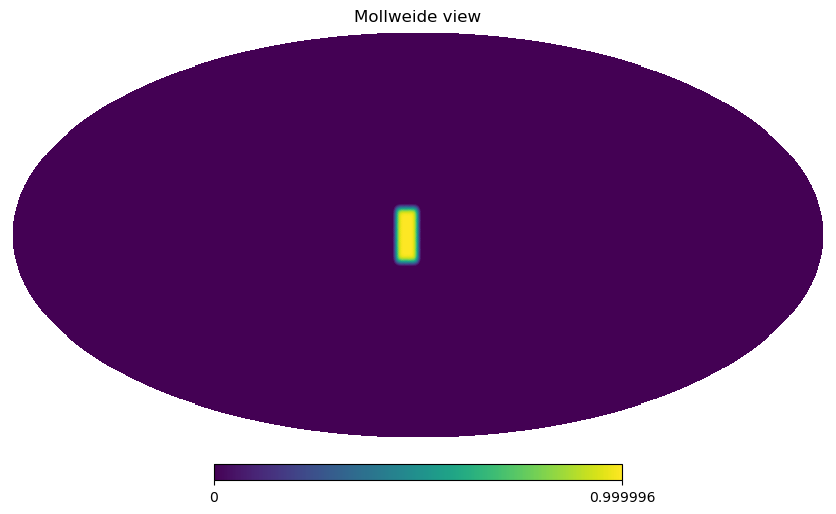

In [8]:
# Example mask
ra = [0,10]
dec = [10,-10]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [11]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

rot_degs = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(percent_diff)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(percent_diff_eb)

Input angles are: [ 3.16627268e+00  1.57392958e-01  3.75192348e+00 -4.25247955e+00
  4.51959250e-01  1.29617124e+00 -2.48558498e-01  1.39630382e+00
  1.57425846e+00 -9.79676671e+00  8.49116384e+00  1.20358658e+00
 -1.09884381e+00  6.12949367e+00  1.81383469e-01  1.50346574e+00
 -5.32470560e+00 -4.20410120e+00  7.48325807e+00 -6.37931052e+00
 -1.81955754e+00  6.18792016e-01  9.82505203e+00  6.04178460e-02
 -2.32919165e+00 -4.69036138e-01  2.37348894e+00  1.83126455e+00
  1.15181695e+01  5.93992237e+00  2.96936794e+00  3.22384514e+00
  3.68951715e-01 -4.41623638e-01  8.76509961e+00  8.64728826e-01
 -6.17730418e+00 -6.13253634e+00  3.82606820e+00  1.25686486e+01
 -6.42102421e-01 -4.96297337e+00 -7.15043378e+00  7.79849401e+00
  3.62238688e+00  6.90448519e+00 -5.17767443e+00 -3.36405821e-01
 -2.73358782e+00  3.43411479e+00  7.61843190e+00 -1.74424878e+00
  3.68019292e+00  4.38979920e+00  2.16175780e+00  4.87366552e+00
  3.44644235e+00 -5.05125012e+00  4.83322639e+00 -1.49387193e+00
 -2.991

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:13:16<00:00, 15.99s/it]

Injected rotation angles: 
[ 3.16627268e+00  1.57392958e-01  3.75192348e+00 -4.25247955e+00
  4.51959250e-01  1.29617124e+00 -2.48558498e-01  1.39630382e+00
  1.57425846e+00 -9.79676671e+00  8.49116384e+00  1.20358658e+00
 -1.09884381e+00  6.12949367e+00  1.81383469e-01  1.50346574e+00
 -5.32470560e+00 -4.20410120e+00  7.48325807e+00 -6.37931052e+00
 -1.81955754e+00  6.18792016e-01  9.82505203e+00  6.04178460e-02
 -2.32919165e+00 -4.69036138e-01  2.37348894e+00  1.83126455e+00
  1.15181695e+01  5.93992237e+00  2.96936794e+00  3.22384514e+00
  3.68951715e-01 -4.41623638e-01  8.76509961e+00  8.64728826e-01
 -6.17730418e+00 -6.13253634e+00  3.82606820e+00  1.25686486e+01
 -6.42102421e-01 -4.96297337e+00 -7.15043378e+00  7.79849401e+00
  3.62238688e+00  6.90448519e+00 -5.17767443e+00 -3.36405821e-01
 -2.73358782e+00  3.43411479e+00  7.61843190e+00 -1.74424878e+00
  3.68019292e+00  4.38979920e+00  2.16175780e+00  4.87366552e+00
  3.44644235e+00 -5.05125012e+00  4.83322639e+00 -1.49387193e+0

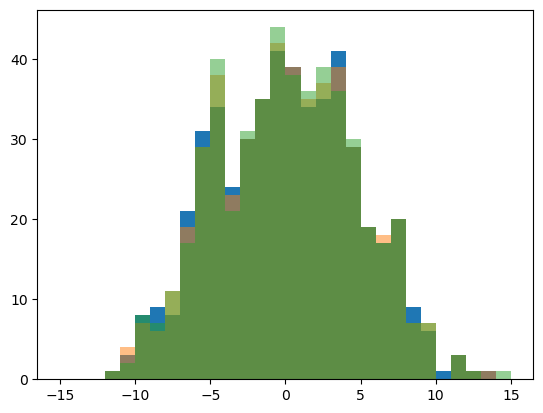

In [23]:
plt.hist(rot_degs, bins=np.arange(31)-15)
plt.hist(output_angles_only,bins=np.arange(31)-15,alpha=0.5)
plt.hist(output_null_eb_angles_only,bins=np.arange(31)-15,alpha=0.5)
plt.show()

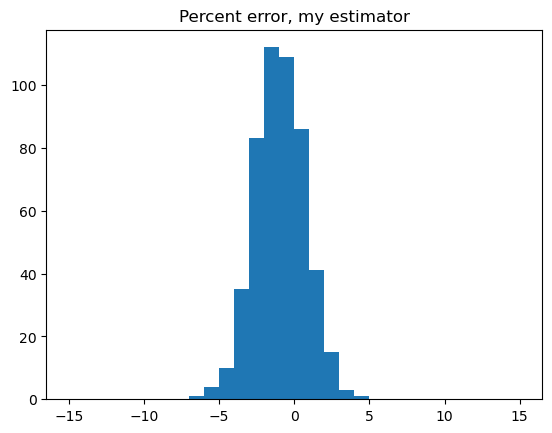

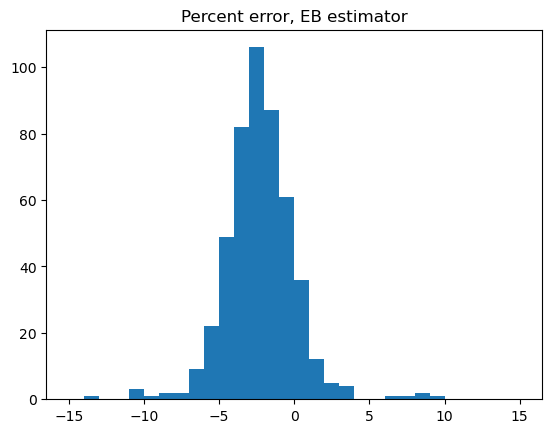

In [26]:
plt.hist(percent_diff, bins=np.arange(31)-15)
plt.title("Percent error, my estimator")
plt.show()
plt.close()
plt.hist(percent_diff_eb, bins=np.arange(31)-15)
plt.title("Percent error, EB estimator")
plt.show()
plt.close()

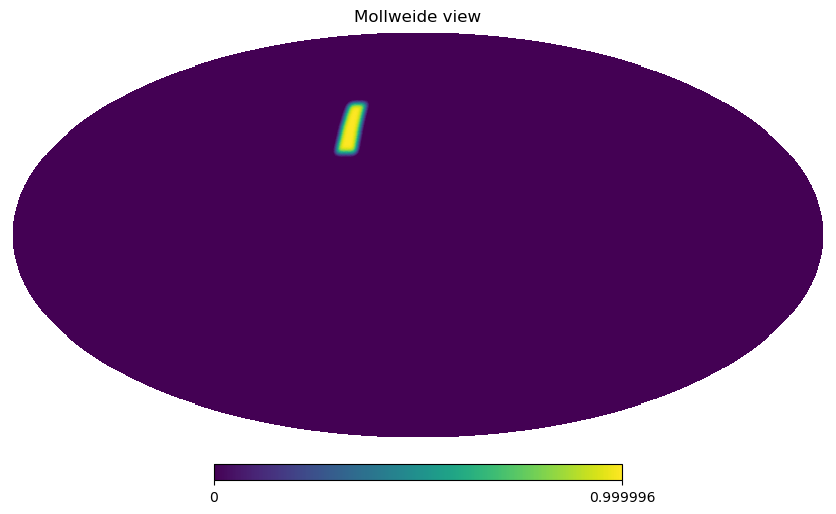

In [6]:
# Example mask
ra = [30,40]
dec = [50,30]
pix = get_pixels(nside, dec, ra)
m = np.zeros(npix)
m[pix] = 1
m[m==0] = -0.1
m_sm = hp.smoothing(m, sigma = 0.02)
m_sm[m_sm < 0] = 0
m_sm /= np.max(m_sm)
hp.mollview(m_sm)

In [9]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_2 = []
output_null_eb_angles_2 = []
tt_bias_outputs = []

rot_degs_2 = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs_2))
rotated_maps = []
for rot_deg in tqdm(rot_degs_2):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles_2.append(fit_values)
    output_null_eb_angles_2.append(null_eb_fit_values)
    
rot_degs_2 = np.array(rot_degs_2)
output_angles_only_2 = np.array(output_angles_2)[:,0]
output_null_eb_angles_only_2 = np.array(output_null_eb_angles_2)[:,0]
percent_diff_2 = 100.0*(output_angles_only_2 - rot_degs_2)/rot_degs_2
percent_diff_eb_2 = 100.0*(output_null_eb_angles_only_2 - rot_degs_2)/rot_degs_2
print("Injected rotation angles: ")
print(rot_degs_2)
print("Recovered angles: ")
print(output_angles_only_2)
print("Percent difference: ")
print(percent_diff_2)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only_2)
print("Percent difference: ")
print(percent_diff_eb_2)

Input angles are: [-1.86432174e-01 -1.72236097e+00 -4.21143382e+00  1.50509595e+00
  5.22731323e+00  5.12549106e+00  8.40693819e+00  1.09617132e+01
 -2.45529337e+00  6.17466236e+00 -7.67364731e+00 -9.91589574e-01
  1.21755331e+00 -3.11828836e+00  3.02353575e+00 -4.86426479e+00
  2.47287765e+00  9.39954934e-01 -1.00359522e+01 -8.61353014e+00
  7.37584238e-01  1.16637438e+01 -7.23638408e+00 -1.79828727e+00
 -2.06975892e+00 -4.52023576e+00 -5.11861759e+00  7.75713381e-01
  1.25842232e+00 -3.11866246e+00  1.85525561e+00  3.14457907e+00
 -2.77787400e+00 -8.83221542e-01 -4.36064004e+00 -2.68786505e+00
 -1.31575740e+00 -3.88636222e+00  3.53423785e+00  6.16558671e+00
 -1.06550169e+00  7.59539568e+00 -2.14503112e+00  8.84135038e+00
  1.72258285e+00  1.00633183e+00 -3.89273289e+00  2.52664371e+00
  6.26047361e+00 -5.18391996e+00 -1.84797841e+01 -2.71878155e-01
  2.12599737e+00  1.73947161e+00  3.19877131e+00 -4.77059570e+00
  4.62224729e+00 -1.15245606e+01  3.74411232e+00 -8.31179401e+00
  6.350

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:14:52<00:00, 16.19s/it]

Injected rotation angles: 
[-1.86432174e-01 -1.72236097e+00 -4.21143382e+00  1.50509595e+00
  5.22731323e+00  5.12549106e+00  8.40693819e+00  1.09617132e+01
 -2.45529337e+00  6.17466236e+00 -7.67364731e+00 -9.91589574e-01
  1.21755331e+00 -3.11828836e+00  3.02353575e+00 -4.86426479e+00
  2.47287765e+00  9.39954934e-01 -1.00359522e+01 -8.61353014e+00
  7.37584238e-01  1.16637438e+01 -7.23638408e+00 -1.79828727e+00
 -2.06975892e+00 -4.52023576e+00 -5.11861759e+00  7.75713381e-01
  1.25842232e+00 -3.11866246e+00  1.85525561e+00  3.14457907e+00
 -2.77787400e+00 -8.83221542e-01 -4.36064004e+00 -2.68786505e+00
 -1.31575740e+00 -3.88636222e+00  3.53423785e+00  6.16558671e+00
 -1.06550169e+00  7.59539568e+00 -2.14503112e+00  8.84135038e+00
  1.72258285e+00  1.00633183e+00 -3.89273289e+00  2.52664371e+00
  6.26047361e+00 -5.18391996e+00 -1.84797841e+01 -2.71878155e-01
  2.12599737e+00  1.73947161e+00  3.19877131e+00 -4.77059570e+00
  4.62224729e+00 -1.15245606e+01  3.74411232e+00 -8.31179401e+0

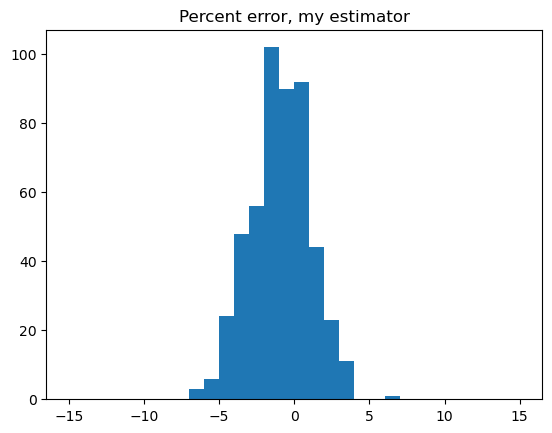

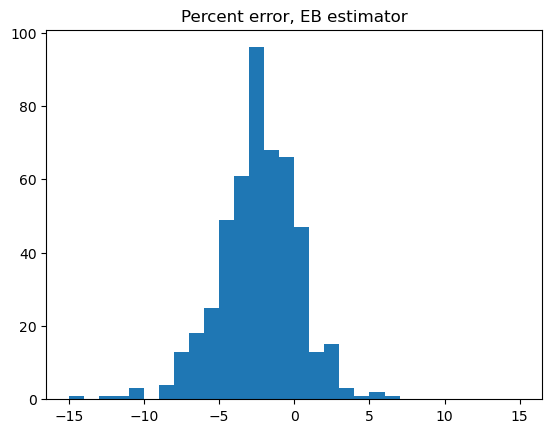

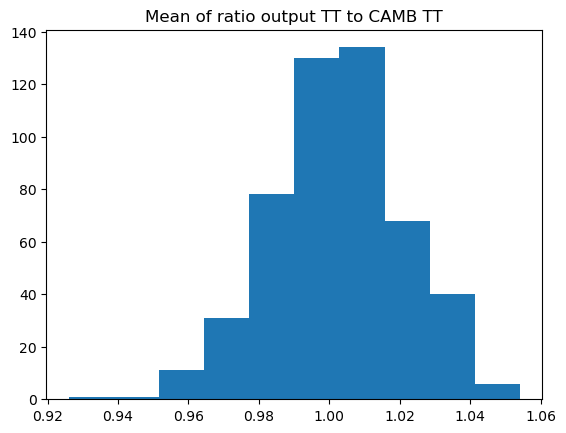

In [14]:
plt.hist(percent_diff_2, bins=np.arange(31)-15)
plt.title("Percent error, my estimator")
plt.show()
plt.close()
plt.hist(percent_diff_eb_2, bins=np.arange(31)-15)
plt.title("Percent error, EB estimator")
plt.show()
plt.close()
plt.hist(tt_bias_outputs)
plt.title("Mean of ratio output TT to CAMB TT")
plt.show()
plt.close()

In [25]:
# Plotting outputs of the likelihood to visually inspect fit

def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2 / (2*sigma**2))

def plot_sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    plt.plot(angles_deg, norm_sampled_likelihood)
    gauss = [gaussian(angle,fit_values[0],fit_values[1]) for angle in angles_deg]
    plt.plot(angles_deg, gauss, '--')
    plt.show()
    
    return fit_values

def plot_sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    plt.plot(angles_deg, norm_sampled_likelihood)
    gauss = [gaussian(angle,fit_values[0],fit_values[1]) for angle in angles_deg]
    plt.plot(angles_deg, gauss, '--')
    plt.show()
    
    return fit_values

Input angles are: [ 6.38833159  2.76459452 -4.14030347 -2.49190635 -1.19665689]


  0%|                                                                                                                                                                          | 0/5 [00:00<?, ?it/s]

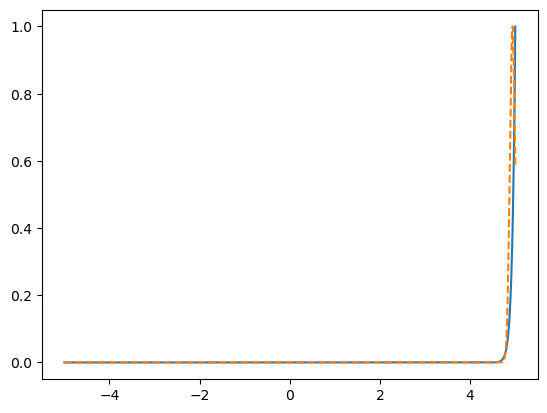

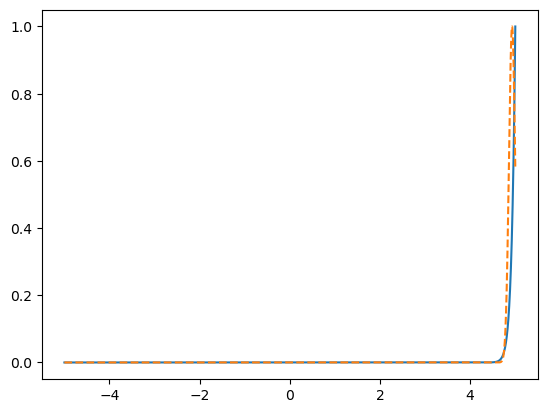

 20%|████████████████████████████████▍                                                                                                                                 | 1/5 [00:17<01:08, 17.08s/it]

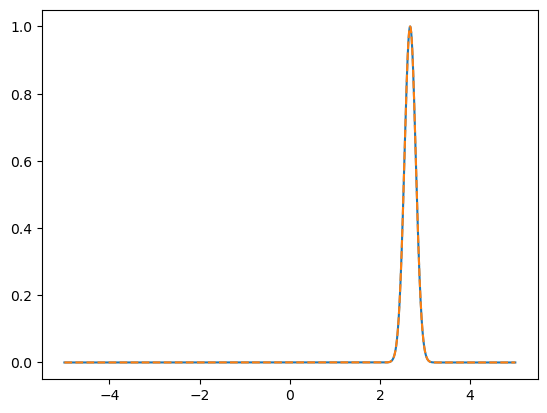

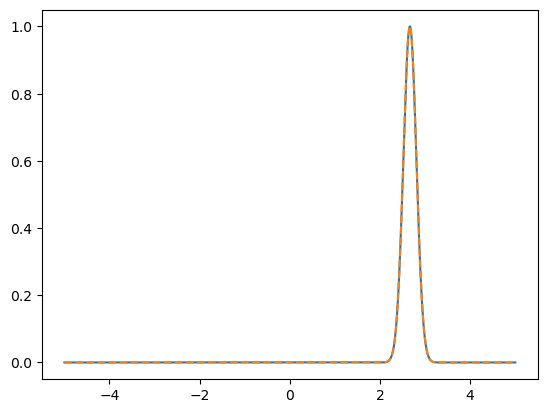

 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 2/5 [00:33<00:50, 16.78s/it]

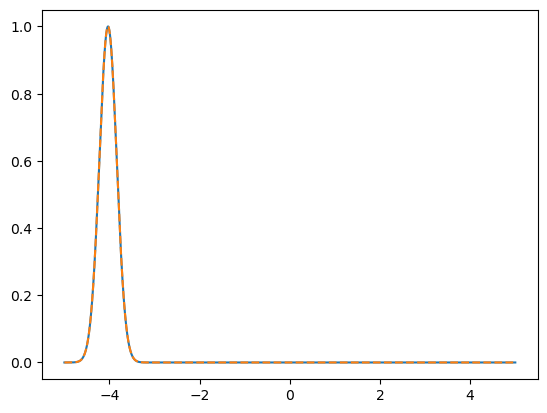

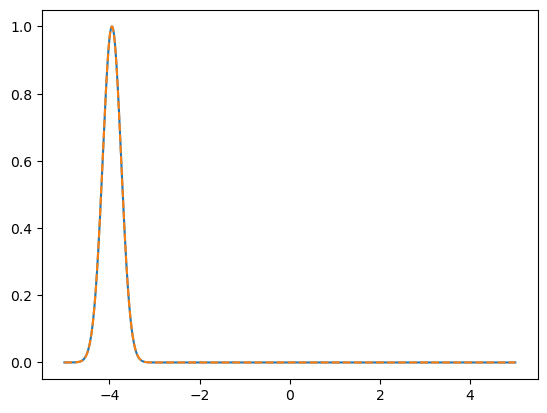

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 3/5 [00:49<00:32, 16.33s/it]

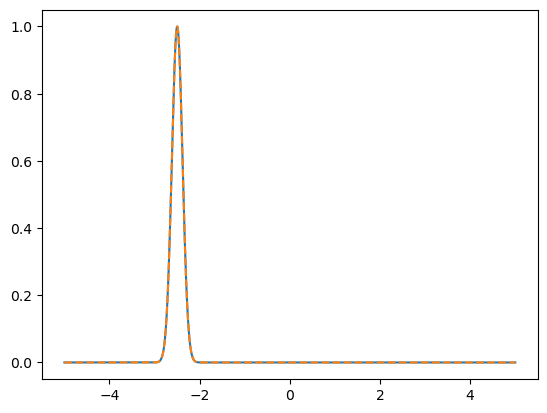

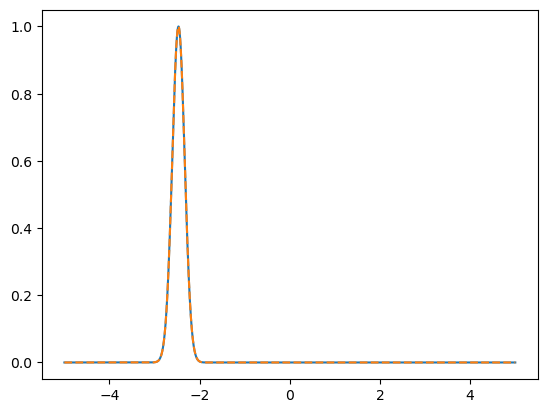

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4/5 [01:05<00:16, 16.22s/it]

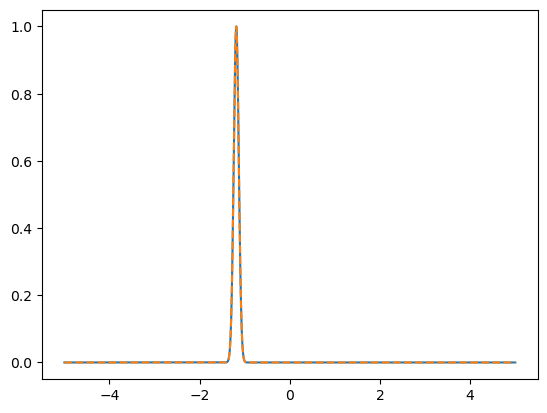

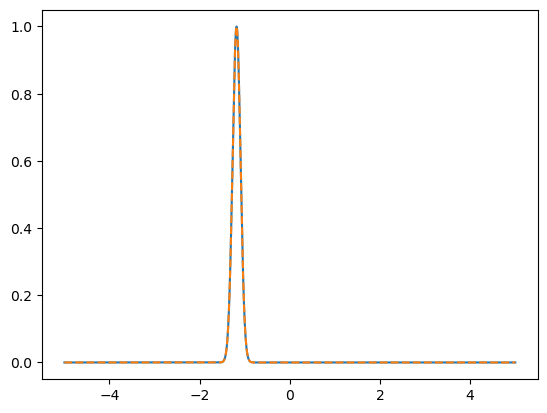

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:22<00:00, 16.41s/it]

Injected rotation angles: 
[ 6.38833159  2.76459452 -4.14030347 -2.49190635 -1.19665689]
Recovered angles: 
[ 4.9385726   2.66746477 -4.03223244 -2.4981257  -1.1881477 ]
Percent difference: 
[-22.69385937  -3.51334504  -2.61022013   0.24958199  -0.71108072]
Recovered null EB angles: 
[ 4.92843586  2.66230436 -3.94621783 -2.47017125 -1.18167383]
Percent difference: 
[-22.85253531  -3.70000586  -4.68771544  -0.87222808  -1.25207634]


In [26]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []
output_null_eb_angles = []

rot_degs = np.random.normal(0, 5, size=(5))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = plot_sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-5.0,angle_max_deg=5.0,num_pts=50000)
    null_eb_fit_values = plot_sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-5.0,angle_max_deg=5.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
print("Injected rotation angles: ")
print(rot_degs)
print("Recovered angles: ")
print(output_angles_only)
print("Percent difference: ")
print(percent_diff)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only)
print("Percent difference: ")
print(percent_diff_eb)

In [29]:
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [31]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_3 = []
output_null_eb_angles_3 = []
tt_bias_outputs_3 = []

rot_degs_3 = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs_3))
rotated_maps = []
for rot_deg in tqdm(rot_degs_3):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs_3.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles_3.append(fit_values)
    output_null_eb_angles_3.append(null_eb_fit_values)
    
rot_degs_3 = np.array(rot_degs_3)
output_angles_only_3 = np.array(output_angles_3)[:,0]
output_null_eb_angles_only_3 = np.array(output_null_eb_angles_3)[:,0]
percent_diff_3 = 100.0*(output_angles_only_3 - rot_degs_3)/rot_degs_3
percent_diff_eb_3 = 100.0*(output_null_eb_angles_only_3 - rot_degs_3)/rot_degs_3
print("Injected rotation angles: ")
print(rot_degs_3)
print("Recovered angles: ")
print(output_angles_only_3)
print("Percent difference: ")
print(percent_diff_3)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only_3)
print("Percent difference: ")
print(percent_diff_eb_3)

Input angles are: [-8.95882990e+00 -5.22972000e+00  4.91017797e+00 -1.77537898e-01
  4.09710634e+00  3.32798495e+00 -1.78884409e-01  4.10022950e+00
  6.76430002e+00 -3.95653606e+00  4.61148466e+00 -6.20643546e+00
 -2.54878471e+00  1.08428794e+00  7.19469131e+00 -4.15727275e+00
  2.24273232e+00  9.11672771e+00  7.09268749e+00 -3.67029098e+00
  3.98117956e+00  1.16113700e+01 -3.30600240e+00 -1.68076182e-01
 -8.13972887e+00 -3.07896087e+00  1.99903329e+00 -3.60313161e+00
 -9.64131200e-01 -6.70953756e-01 -5.97797492e+00 -3.98127730e+00
 -1.74194910e+00 -3.72837828e+00  7.84687141e-01  3.51298763e+00
 -3.45406417e+00  6.71882387e+00  4.31132409e+00 -5.01442330e-01
 -3.95980326e-01  2.38297818e+00  8.14421318e+00  4.07271638e+00
 -4.93221859e+00  3.46971698e+00  4.65765215e+00  3.80651959e+00
  8.60006086e+00  1.00145245e+00  5.31776903e+00 -4.67623181e+00
 -5.22059058e+00  4.30058796e+00  1.85969858e+00  3.86141236e+00
  1.59090132e+00  9.21920478e+00 -5.28874720e+00 -4.66525105e+00
 -5.943

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:07:54<00:00, 15.35s/it]

Injected rotation angles: 
[-8.95882990e+00 -5.22972000e+00  4.91017797e+00 -1.77537898e-01
  4.09710634e+00  3.32798495e+00 -1.78884409e-01  4.10022950e+00
  6.76430002e+00 -3.95653606e+00  4.61148466e+00 -6.20643546e+00
 -2.54878471e+00  1.08428794e+00  7.19469131e+00 -4.15727275e+00
  2.24273232e+00  9.11672771e+00  7.09268749e+00 -3.67029098e+00
  3.98117956e+00  1.16113700e+01 -3.30600240e+00 -1.68076182e-01
 -8.13972887e+00 -3.07896087e+00  1.99903329e+00 -3.60313161e+00
 -9.64131200e-01 -6.70953756e-01 -5.97797492e+00 -3.98127730e+00
 -1.74194910e+00 -3.72837828e+00  7.84687141e-01  3.51298763e+00
 -3.45406417e+00  6.71882387e+00  4.31132409e+00 -5.01442330e-01
 -3.95980326e-01  2.38297818e+00  8.14421318e+00  4.07271638e+00
 -4.93221859e+00  3.46971698e+00  4.65765215e+00  3.80651959e+00
  8.60006086e+00  1.00145245e+00  5.31776903e+00 -4.67623181e+00
 -5.22059058e+00  4.30058796e+00  1.85969858e+00  3.86141236e+00
  1.59090132e+00  9.21920478e+00 -5.28874720e+00 -4.66525105e+0

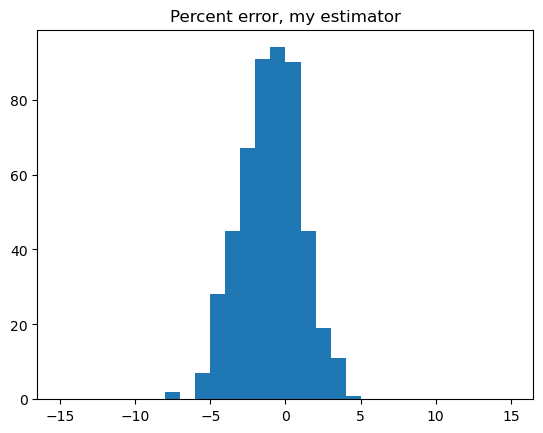

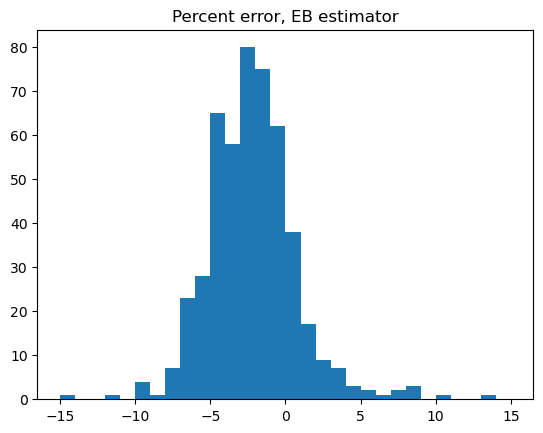

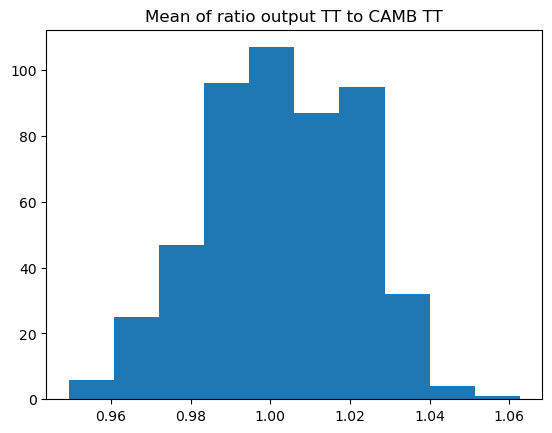

In [32]:
plt.hist(percent_diff_3, bins=np.arange(31)-15)
plt.title("Percent error, my estimator")
plt.show()
plt.close()
plt.hist(percent_diff_eb_3, bins=np.arange(31)-15)
plt.title("Percent error, EB estimator")
plt.show()
plt.close()
plt.hist(tt_bias_outputs_3)
plt.title("Mean of ratio output TT to CAMB TT")
plt.show()
plt.close()

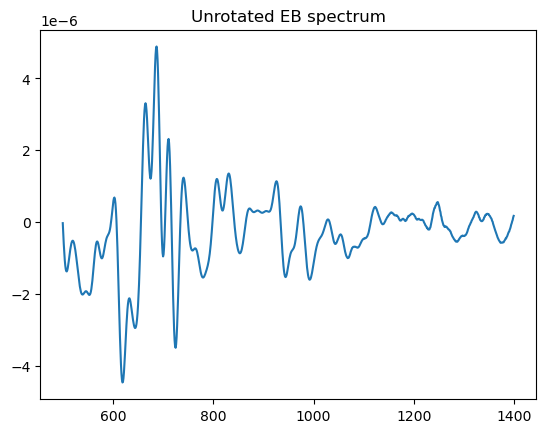

In [34]:
# Plotting the unrot EB spectrum to make sure it is consistent with zero
plt.plot(ell_hp, ClEB_unrot)
plt.title("Unrotated EB spectrum")
plt.show()

3/12/24

One more test to try with the fitting: I am going to use scipy.optimize.curve_fit() to do the fitting to a Gaussian and make sure that it fits the same as the Gaussian moments method. I will also save all 500 unrotated EB spectra so that we can make sure that they are generally consistent with zero. If the TT spectra are unbiased but there is still a bias in the angles, it could be from something weird happening in the other spectra.

In [35]:
from scipy import optimize as op

In [36]:
def gaussian(x,mean,sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data):
    """
       Uses scipy.optimize.curve_fit() to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    guess = [0.1*np.pi/180., 0.5*np.pi/180.]
    popt, pcov = op.curve_fit(gaussian,angles,data,p0=guess)
    return popt[0], np.abs(popt[1])

def sample_likelihood_and_fit_curvefit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit_curvefit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [37]:
# Now make simulated maps, rotate them, mask them with this tapered mask, calculate the spectra with anafast,
# test the w2 map correction, and calculate the angle with the estimator
# Difference from before is that I remake the sims each time

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles_4 = []
output_null_eb_angles_4 = []
tt_bias_outputs_4 = []
output_spectra_4 = []

rot_degs_4 = np.random.normal(0, 5, size=(500))
print("Input angles are: " + str(rot_degs_4))
rotated_maps = []
for rot_deg in tqdm(rot_degs_4):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    # Fixed coordinate system compared to last time
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    unrot_sim_maps_masked = (unrot_sim_maps[0]*m_sm, unrot_sim_maps[1]*m_sm, unrot_sim_maps[2]*m_sm)
    rot_sim_maps = (unrot_sim_maps[0]*m_sm,rot_Q_map*m_sm,rot_U_map*m_sm)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=unrot_sim_maps_masked)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps_masked, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps_masked)
    
    # Calculating w2
    w2 = np.mean(m_sm**2)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] / w2
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] / w2
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] / w2
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] / w2
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] / w2
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] / w2
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell] / w2
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell] / w2
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell] / w2
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell] / w2
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell] / w2
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell] / w2
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell] / w2
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell] / w2
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell] / w2
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell] / w2
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell] / w2
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell] / w2
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell] / w2
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell] / w2
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell] / w2
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell] / w2
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell] / w2
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell] / w2
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra_4.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor - is this still true with mask? I think yes since the FFTs are on the full sky
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit_curvefit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit_curvefit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs_4.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles_4.append(fit_values)
    output_null_eb_angles_4.append(null_eb_fit_values)
    
rot_degs_4 = np.array(rot_degs_4)
output_angles_only_4 = np.array(output_angles_4)[:,0]
output_null_eb_angles_only_4 = np.array(output_null_eb_angles_4)[:,0]
percent_diff_4 = 100.0*(output_angles_only_4 - rot_degs_4)/rot_degs_4
percent_diff_eb_4 = 100.0*(output_null_eb_angles_only_4 - rot_degs_4)/rot_degs_4
print("Injected rotation angles: ")
print(rot_degs_4)
print("Recovered angles: ")
print(output_angles_only_4)
print("Percent difference: ")
print(percent_diff_4)
print("Recovered null EB angles: ")
print(output_null_eb_angles_only_4)
print("Percent difference: ")
print(percent_diff_eb_4)

Input angles are: [-7.03477074e-01 -4.81963465e+00 -3.71059307e+00 -3.66972474e+00
  9.31085816e+00 -2.39815996e+00  3.34645906e+00 -2.07392551e+00
  4.40793072e+00 -1.68264062e+00 -1.95457842e+00 -5.64263138e-01
 -4.24276286e+00  2.28324848e+00 -3.23130023e-01 -1.18665995e+00
  2.55269931e-02 -5.11320258e+00  4.12503899e-01  5.77949458e+00
 -1.26375724e+00 -6.79086585e+00  5.62586857e+00 -1.29500105e+00
  3.55931526e+00  5.56972192e+00 -8.37794940e+00 -1.60418291e+00
  4.87272569e+00  2.53069072e+00 -4.98490720e+00 -4.48464288e+00
 -2.25615897e+00  3.94683351e+00  1.73821252e+00 -9.65372146e+00
 -1.16914552e+00  4.04103795e+00 -1.85742670e+00 -7.68084589e+00
  1.11702959e+01  4.25988795e+00 -7.40901979e-01 -1.17445526e+01
  5.53220067e+00  2.99262929e+00 -6.45375473e+00 -9.86908533e+00
  6.97216381e+00  4.87912567e+00 -9.91425729e+00  2.20605674e+00
  2.85305960e+00 -4.86417085e+00  4.56706401e+00  7.55654988e+00
 -1.45845503e+00 -6.01347985e+00  4.61927141e+00 -5.30579846e+00
 -2.869

  1%|██▏                                                                                                                                                           | 7/500 [01:46<2:03:47, 15.07s/it]/home/zbh5/anaconda3/envs/act_analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 297/500 [1:16:52<52:32, 15.53s/it]


RuntimeError: Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.

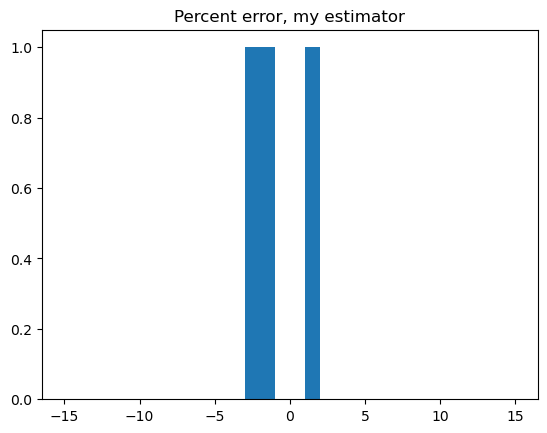

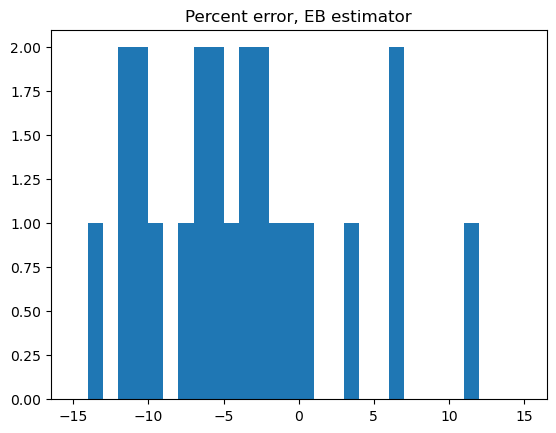

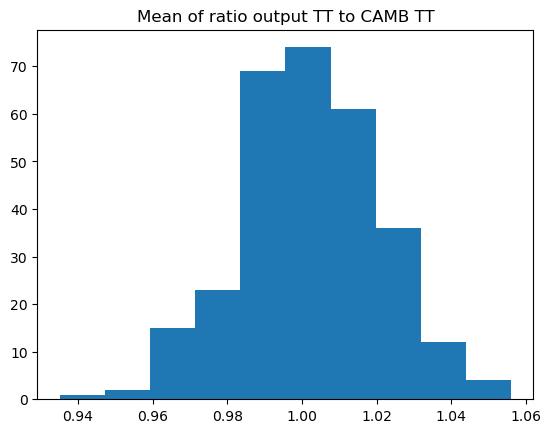

In [46]:
rot_degs_4 = np.array(rot_degs_4)
output_angles_only_4 = np.array(output_angles_4[:295])[:,0]
output_null_eb_angles_only_4 = np.array(output_null_eb_angles_4[:295])[:,0]
percent_diff_4 = 100.0*(output_angles_only_4 - rot_degs_4)/rot_degs_4
percent_diff_eb_4 = 100.0*(output_null_eb_angles_only_4 - rot_degs_4)/rot_degs_4

plt.hist(percent_diff_4, bins=np.arange(31)-15)
plt.title("Percent error, my estimator")
plt.show()
plt.close()
plt.hist(percent_diff_eb_4, bins=np.arange(31)-15)
plt.title("Percent error, EB estimator")
plt.show()
plt.close()
plt.hist(tt_bias_outputs_4)
plt.title("Mean of ratio output TT to CAMB TT")
plt.show()
plt.close()

In [47]:
percent_diff_4

array([-108.3091902 , -102.06601191, -102.68351242, -102.71339768,
        -98.93055802, -104.15162058,  -97.02448911, -104.79262352,
        -97.74102108, -105.83758277, -105.08978066, -110.00121513,
       -102.34691943,  -95.63833699, -120.41592746, -107.07572776,
        276.19904957, -101.9473945 ,  -62.47367027,  -98.27711187,
       -106.93062738, -101.46629647,  -98.23006484, -106.9524931 ,
        -97.202433  ,  -98.21222267, -101.18852742, -106.05073443,
        -97.95649843,  -96.06410785, -101.99751413, -102.22033791,
       -104.41147069,  -97.47711106,  -93.91678588, -101.03145949,
       -107.08441971,  -97.5359245 , -105.37188079, -101.29639661,
        -99.10858023,  -97.66251537, -107.89672266, -100.84783328,
        -98.20009736,  -96.67253806, -101.54288829, -101.00895091,
        -98.57183181,  -97.9591789 , -101.00435386,  -95.42420113,
        -96.50974532, -102.04709556,  -97.8197322 ,  -98.68227925,
       -106.58837582, -101.65585033,  -97.84437378, -101.87670